# YOLO

## Introduction
Object detection is a fundamental task in computer vision. The problem of object recognition essentially consists of first localizing the object and then classifying it with a semantic label. In recent deep learning based methods, YOLO is an extremely fast real time multi object detection algorithm.  
  
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_1.png"/></div>
<center>Figure 1: This is a demo of what object detection does. The color indicates different semantic class.</center>  
  
In this project, we provide 10K street scene images with correponding labels as training data. The image dimension is $128 \times 128 \times 3$, and the labels include the semantic class and the bounding box corresponding to each object in the image. Note that a small portion of these ground-truth labels are not a little bit noisy and the quantity of the training set is not very large, so we do not expect you to learn a super robust object detector.

## Data Preprocessing
For this section, you will need to write code to preprocess the ground truth labels for the YOLO algorithm. The
labels are provided in the "label" folder. The format of the labels are (class, $x_1$, $y_1$, $x_2$, $y_2$), where $x_1$, $y_1$ are the top left corner of the bounding box and $x_2$, $y_2$ are the bottom right corner of the bounding box.  
  
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_2.png"/></div>
<center>Figure 2: This figure demonstrates the format of ground-truth labels that YOLO algorithm requires.</center>  
  
For each image, you are required to convert the provided labels into the $8 \times 8 \times 8$ ground truth matrix, which has the same dimension as the output of YOLO detection network. The instructions of this conversion is as follows:
* We consider a $16 \times 16$ image patch as a grid cell and thus divide the full image into $8 \times 8$ patches in the 2D spatial dimension. In the output activation space, one grid cell represents one 16x16 image patch with corresponding aligned locations.
* For simplified YOLO, we only use one anchor box, where we assume the anchor size is the same as the grid cell size. If the center of an object falls into a grid cell, that grid cell is responsible for detecting that object. This means that there is only one anchor for each object instance.
* For each anchor, there are 8 channels, which encode Pr(Objectness), $x$, $y$, $w$, $h$, P(class=pedestrian),  P(class=traffic light), and P(class=car).
* The Pr(Objectness) is the probability of whether this anchor is an object or background. When assigning the ground-truth for this value, "1" indicates object and "0" indicates background.
* The channels 2-5, $x$, $y$ coordinates represent the center of the box relative to the bounds of the grid cell; $w$, $h$ is relative to the image width and height.
* In channels 6-8, you need to convert the ground truth semantic label of each object into one-hot coding for each anchor boxes.
* Note that if the anchor box does not have any object (Pr=0), you donâ€™t need to assign any values to channels 2-8, since we will not use them during training.
* The dimensions are ordered (channels, x, y).

## Model Architecture
You are required to implement the model architecture using the following parameters. This model takes input with dimension of $128 \times 128 \times 3$ and outputs an activation with dimension of $8 \times 8 \times 8$.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_3.png"/></div>
<center>Figure 3: This figure demonstrates how to compute IoU.</center>

| Layer | Hyperparameters |
| :-: | :-: |
| conv1 | Kernel size $= 4 \times 4 \times 32$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv2 | Kernel size $= 4 \times 4 \times 64$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv3 | Kernel size $= 4 \times 4 \times 128$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv4 | Kernel size $= 4 \times 4 \times 256$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv5 | Kernel size $= 4 \times 4 \times 512$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv6 | Kernel size $= 4 \times 4 \times 1024$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| transposed_conv7 | Kernel size $= 4 \times 4 \times 256$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| transposed_conv8 | Kernel size $= 4 \times 4 \times 64$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv9 | Kernel size $= 3 \times 3 \times 8$, stride $=1$, pad $=1$. |


## Training Details
During training, the localization and classification errors are optimized jointly. The loss function is shown
as below.  $i$ indicates number of grid cells and $j$ indicates number of anchor boxes at each grid cell. In our
case, there is only one anchor box at each grid cell and $B = 1$.

$$ \text{Loss} =
{\lambda_\text{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left[{\left(x_i - \hat{x}_i\right)}^2 + {\left(y_i - \hat{y}_i\right)}^2\right]} +
{\lambda_\text{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left[{\left(\sqrt{w_i} - \sqrt{\hat{w}_i}\right)}^2 + {\left(\sqrt{h_i} - \sqrt{\hat{h}_i}\right)}^2\right]} +
{\sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left(C_i - \hat{C}_i\right)^2} +
{\lambda_\text{no obj} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{no obj} \left(C_i - \hat{C}_i\right)^2} +
{\sum_{i=0}^{S^2} \mathbb{1}_{ij}^\text{obj} \sum_{c\, \in\, \text{classes}} \left(p_i(c) - \hat{p}_i(c)\right)^2}$$

* In our case there is only one anchor box at each grid, hence $B = 1$.
* $S^2 =$ total number of grid cells.
* $\mathbb{1}_{ij}^\text{obj} = 1$ if an object appears in grid cell $i$ and 0 otherwise.
* $\mathbb{1}_{ij}^\text{no obj}$ is the compliment of $\mathbb{1}_{ij}^\text{obj}$.
* $\hat{C}_i =$ Box confidence score $=$ Pr(box contains object) $\times$ IoU
* IoU $=$ Intersection over union between the predicted and the ground truth.
* $\hat{p}_i(c) =$ conditional class probability of class $c$ in cell $i$.

$\lambda_\text{coord}$ and and $\lambda_\text{no obj}$ are two hyperparameters for coordinate predictions and non-objectness classification. We set $\lambda_\text{coord} = 5$ and and $\lambda_\text{no obj} = 0.5$.

Each grid cell predicts 1 bounding box, confidence score for those boxes and class conditional probabilities.

The confidence Score reflects the degree of confidence that the box contains an object and how accurate the box is. If no object exists in the cell then the confidence score should be 0 else the confidence score should be equal to the IOU between the predicted box and the ground truth box.

During training, you can set learning rate of 10e-3 using Adam optimizer with default beta 1 and beta 2. You are encourage to adaptively adjust learning rate during training to see if the model will converge better. You should also visualize the loss over training iterations. You will need to decide at the iteration to stop training based on the loss visualization. (At least 20 epochs of training is required.)

## Post-Processing
During inference, the network is going to predict lots of overlapping redundant bounding boxes. To eliminate the redundant boxes, there are basically two steps:

1. Get rid of predicted boxes with low objectness probability (Pr $< 0.6$).
2. For each class, calculate the IoU for all the bounding boxes and cluster boxes with IoU > 0.5 as a group. For each group, find the one with highest Pr and suppress the other boxes. This is referred as non-max suppression.

To evaluate the performance of your YOLO implementation, compute the mean Average Precision (mAP) of inference. Predicted bounding boxes are a match with ground truth bounding boxes if they share the same label and have an IoU with the ground truth bounding box of greater than 0.5. These matches can be used to calculate a precision/recall curve for each class. The Average Precision for a class is the area under this curve. The mean of these Average Precision values over all the classes in inference gives the mean Average Precision of your network.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_4.png"/></div>
<center>Figure 4: This figure demonstrates post-process of how to get rid of redundant bounding box.</center>

## Code

In [ ]:
!pip install pytorch_lightning &> /dev/null

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
seed = 17
torch.manual_seed(seed)

In [ ]:
# download the data
# if this fails, you can download manually and upload to colab
# manual download link: https://drive.google.com/file/d/1NzN5m3aaQ5XpSEV6toRZiUAGvSh4Ojs4/view?usp=sharing
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1NzN5m3aaQ5XpSEV6toRZiUAGvSh4Ojs4' -O labels.npz
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1MT-J-hgix3BX7HpUumNQiX5J-By47vt1&confirm=t&uuid=e26a8982-e398-4c5e-974d-1459e3599e6c&at=AB6BwCBY6SHI_fcCMpuRgoG38F7K:1694019172385' -O images.npz

--2023-09-25 00:18:58--  https://drive.google.com/uc?export=download&id=1NzN5m3aaQ5XpSEV6toRZiUAGvSh4Ojs4
Resolving drive.google.com (drive.google.com)... 142.251.2.139, 142.251.2.100, 142.251.2.101, ...
Connecting to drive.google.com (drive.google.com)|142.251.2.139|:443... connected.
HTTP request sent, awaiting response... ^C
--2023-09-25 00:18:58--  https://drive.google.com/uc?export=download&id=1MT-J-hgix3BX7HpUumNQiX5J-By47vt1&confirm=t&uuid=e26a8982-e398-4c5e-974d-1459e3599e6c&at=AB6BwCBY6SHI_fcCMpuRgoG38F7K:1694019172385
Resolving drive.google.com (drive.google.com)... 142.251.2.139, 142.251.2.100, 142.251.2.101, ...
Connecting to drive.google.com (drive.google.com)|142.251.2.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1gi8mg9hidf6kppitabkvlc0t31f9snv/1695601125000/14871726518408366222/*/1MT-J-hgix3BX7HpUumNQiX5J-By47vt1?e=download&uuid=e26a8982-

In [ ]:
# Use this function to import the provided data files
def load_data(file_name):
    return np.load(file_name, allow_pickle=True, encoding='latin1')['arr_0']

import traceback
try:
  images = load_data('images.npz')
  raw_labels = load_data('labels.npz')
except Exception as e:
  print(e)
  traceback.print_exc()
  print("load failed, maybe manual download")

In [ ]:
# This function should compute the 8X8X8 label from the raw labels for the corresponding image.
def process_labels(raw_labels):
    """
    Transforms raw bounding box labels into YOLO grid format.

    Args:
    raw_labels: A list of shape (N_image, (N_box, 5)), containing bounding boxes for each image.

    Returns:
    ground_truth_labels: A list of shape [N_image, 8, 8, 8], containing transformed labels.
    """

    ground_truth_labels = list()
    grid_size = 16

    for image_idx in range( len( raw_labels ) ):
        ground_truth_label = np.zeros((  8, 8, 8 ))

        bb_centres_x = ( raw_labels[ image_idx ][ :, 1] + raw_labels[ image_idx ][ :, 3] ) / 2
        bb_centres_y = ( raw_labels[ image_idx ][ :, 2] + raw_labels[ image_idx ][ :, 4] ) / 2

        grid_cell_index_x = ( bb_centres_x // grid_size ).astype( int )
        grid_cell_index_y = ( bb_centres_y // grid_size ).astype( int )

        anchor_boxes_centre_x = ( bb_centres_x % grid_size ) / grid_size
        anchor_boxes_centre_y = ( bb_centres_y % grid_size ) / grid_size

        anchor_boxes_width = ( raw_labels[ image_idx ][ :, 3] - raw_labels[ image_idx ][ :, 1] ) / 128
        anchor_boxes_height = ( raw_labels[ image_idx ][ :, 4] - raw_labels[ image_idx ][ :, 2] ) / 128

        ground_truth_label[ 0, grid_cell_index_x, grid_cell_index_y ] = 1
        ground_truth_label[ 1, grid_cell_index_x, grid_cell_index_y ] = anchor_boxes_centre_x
        ground_truth_label[ 2, grid_cell_index_x, grid_cell_index_y ] = anchor_boxes_centre_y
        ground_truth_label[ 3, grid_cell_index_x, grid_cell_index_y ] = anchor_boxes_width
        ground_truth_label[ 4, grid_cell_index_x, grid_cell_index_y ] = anchor_boxes_height

        ground_truth_label[ raw_labels[ image_idx ][ :, 0].astype( int ) + 5, grid_cell_index_x, grid_cell_index_y ] = 1

        for i in range( len( raw_labels[image_idx] ) ):
            abc = raw_labels[ image_idx ][ i, 0].astype( int )
            if abc == 0:
                ground_truth_label[ abc + 5, grid_cell_index_x[i], grid_cell_index_y[i] ] = 1
                ground_truth_label[ abc + 6, grid_cell_index_x[i], grid_cell_index_y[i] ] = 0
                ground_truth_label[ abc + 7, grid_cell_index_x[i], grid_cell_index_y[i] ] = 0
            elif abc == 1:
                ground_truth_label[ abc + 4, grid_cell_index_x[i], grid_cell_index_y[i] ] = 0
                ground_truth_label[ abc + 5, grid_cell_index_x[i], grid_cell_index_y[i] ] = 1
                ground_truth_label[ abc + 6, grid_cell_index_x[i], grid_cell_index_y[i] ] = 0
            elif abc == 2:
                ground_truth_label[ abc + 3, grid_cell_index_x[i], grid_cell_index_y[i] ] = 0
                ground_truth_label[ abc + 4, grid_cell_index_x[i], grid_cell_index_y[i] ] = 0
                ground_truth_label[ abc + 5, grid_cell_index_x[i], grid_cell_index_y[i] ] = 1

        ground_truth_labels.append( ground_truth_label )


    return ground_truth_labels # [N_image, 8, 8, 8]

In [ ]:
# This function should perform the inverse operation of process_labels().
def reconstruct_raw_labels(labels, img_dim=128, include_score=False):
    """
    Convert grid-based tensor labels back to raw bounding box labels.

    Args:
    labels: A list of shape [N_image, 8, 8, 8], containing transformed labels.
    img_dim: An integer, the size of the image. Default is 128.
    include_score: A boolean, whether to include the score in the output or not. Default is False.

    Returns:
    raw_labels: A list of shape [N_image, (N_box, 5/6)], containing bounding boxes for each image.
    """

    grid_size = 16
    reconstructed_labels = []

    for img_labels in labels:
        # Get the grid coordinates where there's an object
        grid_x, grid_y = np.where(img_labels[0, :, :] == 1)

        # Extract bounding box attributes from the labels
        rel_x_centers = img_labels[1, grid_x, grid_y]
        rel_y_centers = img_labels[2, grid_x, grid_y]
        rel_widths = img_labels[3, grid_x, grid_y]
        rel_heights = img_labels[4, grid_x, grid_y]

        # Convert relative coordinates and sizes to image coordinates and sizes
        abs_x_centers = grid_size * (rel_x_centers + grid_x)
        abs_y_centers = grid_size * (rel_y_centers + grid_y)
        abs_widths = rel_widths * img_dim
        abs_heights = rel_heights * img_dim

        # Get the class information
        class_info = img_labels[5:, grid_x, grid_y]
        class_category = np.argmax(class_info, axis=0)

        # Calculate the corners of the bounding boxes
        x1 = abs_x_centers - abs_widths/2
        y1 = abs_y_centers - abs_heights/2
        x2 = abs_x_centers + abs_widths/2
        y2 = abs_y_centers + abs_heights/2

        # Form the final label data for the current image
        if include_score:
            score = np.max(class_info, axis=0)
            curr_img_labels = np.vstack((class_category, score, x1, y1, x2, y2)).T.astype(int)
        else:
            curr_img_labels = np.vstack((class_category, x1, y1, x2, y2)).T.astype(int)

        reconstructed_labels.append(curr_img_labels)

    # Convert the list to the desired format
    raw_labels = np.array(reconstructed_labels)

    return raw_labels


In [ ]:
def IoU_calc(box1, box2):
    """
    Calculate the Intersection over Union (IoU) between two bounding boxes.

    Args:
    - box1: A list/tensor containing [x1, y1, x2, y2] coordinates of the first box.
    - box2: A list/tensor containing [x1, y1, x2, y2] coordinates of the second box.

    Returns:
    - iou: A scalar tensor representing the IoU between the two boxes.
    """

    # Find coordinates of the intersection rectangle
    x1 = torch.max(box1[0], box2[0])
    y1 = torch.max(box1[1], box2[1])
    x2 = torch.min(box1[2], box2[2])
    y2 = torch.min(box1[3], box2[3])

    # Compute area of the intersection rectangle
    intersection_area = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)

    # Compute area of both boxes
    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Compute the union of both boxes
    union = area_box1 + area_box2 - intersection_area

    # Compute the IoU
    iou = intersection_area / (union + 1e-6)

    return torch.clamp(iou, 0, 1)  # Ensuring the IoU value lies between 0 and 1

def yolo_loss(output, target):
    """
    Compute the YOLO loss between the model output and the target.
    Args:
        output: Tensor, predicted values [B, 8, 8, 8]
        target: Tensor, ground truth values [B, 8, 8, 8]
    Returns:
        Scalar tensor, the computed loss
    """
    # Define constants
    lambda_coordinate = 5
    lambda_non_objectness = 0.5

    # Find indices of cells with and without objects
    object_indices = torch.nonzero(target[:, 0, :, ] != 0)
    no_object_indices = torch.nonzero(target[:, 0, :, ] == 0)

    # Filter outputs and targets based on object presence
    target_objects = target[object_indices[:, 0], :, object_indices[:, 1], object_indices[:, 2]]
    output_objects = output[object_indices[:, 0], :, object_indices[:, 1], object_indices[:, 2]]

    # Compute the difference for location predictions
    location_loss_xy = torch.sum((target_objects[:, 1:3] - output_objects[:, 1:3]) ** 2)
    location_loss_wh = torch.sum((torch.sqrt(target_objects[:, 3:5]) - torch.sqrt(output_objects[:, 3:5])) ** 2)
    location_loss = lambda_coordinate * (location_loss_xy + location_loss_wh)

    # Compute classification loss
    classification_loss = torch.sum((target_objects[:, 5:] - output_objects[:, 5:]) ** 2)

    # Compute Intersection over Union (IoU) for objectness score calculation
    # This assumes an external function called IoU_calc
    predicted_box = get_box_coordinates(output_objects, object_indices)
    target_box = get_box_coordinates(target_objects, object_indices)
    iou = IoU_calc(predicted_box, target_box)

    # Compute objectness losses
    objectness_loss = torch.sum(target_objects[:, 0] * (iou - output_objects[:, 0]) ** 2)
    no_object_targets = target[no_object_indices[:, 0], :, no_object_indices[:, 1], no_object_indices[:, 2]]
    no_object_outputs = output[no_object_indices[:, 0], :, no_object_indices[:, 1], no_object_indices[:, 2]]
    no_object_loss = lambda_non_objectness * torch.sum(no_object_targets[:, 0] * (0 - no_object_outputs[:, 0]) ** 2)

    confidence_loss = objectness_loss + no_object_loss

    # Total loss
    loss = location_loss + confidence_loss + classification_loss

    return loss

def get_box_coordinates(box_tensor, indices):
    """
    Extract the coordinates for the bounding boxes.
    Args:
        box_tensor: Tensor with YOLO predictions/targets
        indices: Tensor with indices of the cells
    Returns:
        List of bounding box coordinates
    """
    x_center, y_center = (box_tensor[:, 1] + indices[:, 0]) * 16, (box_tensor[:, 2] + indices[:, 1]) * 16
    width, height = box_tensor[:, 3] * 128, box_tensor[:, 4] * 128

    # Convert center coordinates to top-left and bottom-right
    x1, y1 = x_center - width/2, y_center - height/2
    x2, y2 = x_center + width/2, y_center + height/2

    return [x1, y1, x2, y2]


# Part B

In [ ]:
import torch.nn as nn
import pytorch_lightning as pl

class YOLO(pl.LightningModule):
    def __init__(self):
        super(YOLO, self).__init__()

        self.feature_layers = nn.Sequential(
            torch.nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 4, stride=2, padding=1),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 4, stride=2, padding=1),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 4, stride=2, padding=1),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 4, stride=2, padding=1),
            torch.nn.BatchNorm2d(num_features=256),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 4, stride=2, padding=1),
            torch.nn.BatchNorm2d(num_features=512),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 4, stride=2, padding=1),
            torch.nn.BatchNorm2d(num_features=1024),
            torch.nn.ReLU()
        )

        self.decoder_layers = nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels = 1024, out_channels = 256, kernel_size = 4, stride=2, padding=1),
            torch.nn.BatchNorm2d(num_features=256),
            torch.nn.ReLU(),

            torch.nn.ConvTranspose2d(in_channels = 256, out_channels = 64, kernel_size = 4, stride=2, padding=1),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 64, out_channels = 8, kernel_size = 3, stride=1, padding=1),
            torch.nn.Sigmoid()
        )

        self.train_losses = []
        self.val_losses = []
        self.predictions_per_batch = []
        self.predictions_per_epoch = []

    def forward(self, x):
        x = self.feature_layers(x)
        return self.decoder_layers(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        images = images.view( len(images), 3, 128, 128).float()
        labels = labels.float()

        outputs = self(images)
        self.predictions_per_batch.append(outputs)

        loss = yolo_loss(outputs, labels)
        self.train_losses.append(loss.item())
        self.log('training_loss', loss)
        return loss

    def on_train_epoch_end(self):
        self.predictions_per_epoch.append(self.predictions_per_batch)
        self.predictions_per_batch.clear()

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        images = images.view(len(images), 3, 128, 128).float()
        labels = labels.float()

        outputs = self(images)
        loss = yolo_loss(outputs, labels)
        self.val_losses.append(loss.item())
        self.log('validation_loss', loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [ ]:
def low_confidence_suppression( label, threshold=0.6 ):
    return torch.where( label[ 0, :, : ] > threshold, label[ :, :, : ], 0 )

def compute_iou(box1, box2):
    # Determine coordinates of the intersection rectangle
    x_left = max(box1[1] - box1[3]/2, box2[1] - box2[3]/2)
    y_left = max(box1[2] - box1[4]/2, box2[2] - box2[4]/2)
    x_right = min(box1[1] + box1[3]/2, box2[1] + box2[3]/2)
    y_right = min(box1[2] + box1[4]/2, box2[2] + box2[4]/2)

    # Compute intersection area
    intersection_area = max(0, x_right - x_left) * max(0, y_right - y_left)

    # Compute areas of both boxes
    box1_area = box1[3] * box1[4]
    box2_area = box2[3] * box2[4]

    # Compute union area
    union_area = box1_area + box2_area - intersection_area

    # Compute IoU
    iou = intersection_area / (union_area + 1e-6)
    return iou

def nms_for_class(obj_class, threshold):
    obj_class = sorted(obj_class, key=lambda x: x[-1], reverse=True)  # Sort by confidence score

    retained_boxes = []

    while obj_class:
        top_box = obj_class.pop(0)
        retained_boxes.append(top_box)

        obj_class = [box for box in obj_class if compute_iou(top_box, box) <= threshold]

    return retained_boxes

def non_max_suppression(label, nms_thres=0.5):
    confidence = reconstruct_raw_labels(label.cpu().detach().numpy(), conf=True, thr=0.6)
    nms_batch = []

    for each_label in confidence:
        person_max = nms_for_class([box for box in each_label if box[0] == 0.], nms_thres)
        traffic_light_max = nms_for_class([box for box in each_label if box[0] == 1.], nms_thres)
        car_max = nms_for_class([box for box in each_label if box[0] == 2.], nms_thres)

        nms_batch.append([person_max, traffic_light_max, car_max])

    return nms_batch

In [ ]:
def compute_box_tensor_coordinates(label):
    """
    Convert center, width, height format to top-left, bottom-right format.
    """
    if label.shape[0] == 0:
        return torch.from_numpy(label)

    x1 = torch.tensor(((label[:, 0] - label[:, 2]) / 2).reshape(-1, 1))
    y1 = torch.tensor(((label[:, 1] - label[:, 3]) / 2).reshape(-1, 1))
    x2 = torch.tensor(((label[:, 0] + label[:, 2]) / 2).reshape(-1, 1))
    y2 = torch.tensor(((label[:, 1] + label[:, 3]) / 2).reshape(-1, 1))

    return torch.hstack((x1, y1, x2, y2))

def precision_recall_curve(predictions, targets, target_class):
    """
    Calculate precision and recall curve data.
    """
    iou_threshold = 0.5
    total_ground_truth_count = 0  # Total ground truth count
    total_positives = []  # List to store positives

    for predicted_label, target_label in zip(predictions, targets):

        if predicted_label is None:
            continue

        predicted_class_label = predicted_label[ predicted_label[ :, 0 ] == target_class ]
        target_class_label = target_label[ target_label[ :, 0 ] == target_class ]

        # Case: No targets for predictions
        if predicted_class_label.shape[0] != 0 and target_class_label.shape[0] == 0:
            total_positives.extend([torch.tensor([p[-1], 1]) for p in predicted_class_label])
            continue

        # Case: No predictions for targets
        elif predicted_class_label.shape[0] == 0 and target_class_label.shape[0] != 0:
            total_ground_truth_count += target_class_label.shape[0]
            total_positives.extend([torch.tensor([t[-1], 0]) for t in target_class_label])
            continue

        # Case: No predictions and targets
        elif predicted_class_label.shape[0] == 0 and target_class_label.shape[0] == 0:
            continue

        predicted_bounding_box = compute_box_tensor_coordinates( predicted_class_label[:, -4:] )
        target_bounding_box = compute_box_tensor_coordinates( target_class_label[:, -4:] )

        iou_matrix = torchvision.ops.box_iou( predicted_bounding_box, target_bounding_box )
        matched_indices = []

        for i, iou_row in enumerate(iou_matrix):
            max_iou_value, index_to_max_iou_value = iou_row.max(0)
            if max_iou_value.item() > iou_threshold:
                if max_iou_value.item() > iou_threshold:
                    if index_to_max_iou_value.item() not in matched_indices:
                        total_positives.append( torch.tensor([ predicted_class_label[i, -1], 1 ]))
                        matched_indices.append( index_to_max_iou_value.item() )
                    else:
                        total_positives.append( torch.tensor([ predicted_class_label[i, -1], 2 ]))
                else:
                    total_positives.append( torch.tensor([ predicted_class_label[i, -1], 2 ]))

        total_ground_truth_count += target_class_label.shape[0]

    if not total_positives:
        return [0], [0]

    sorted_positives = torch.stack(total_positives).sort(0)[0]
    precision = []
    recall = []
    true_positives = 0  # True Positives
    false_positives = 0  # False Positives

    for i, (_, label) in enumerate(sorted_positives):
        if int(label) == 1:
            true_positives += 1
        precision.append(true_positives / (i + 1))
        recall.append(true_positives / (total_ground_truth_count + 1e-5))

    return torch.Tensor(recall), torch.Tensor(precision)

def auc_torch(recall, precision):
    """
    Compute AUC using the trapezoidal rule.
    """
    sorted_indices = torch.argsort(recall)
    sorted_recall = torch.index_select(recall, 0, sorted_indices)
    sorted_precision = torch.index_select(precision, 0, sorted_indices)
    # Compute the differences in recall values
    d_recall = sorted_recall[1:] - sorted_recall[:-1]
    # Compute the average precision values for the trapezoidal rule
    avg_precision = (sorted_precision[1:] + sorted_precision[:-1]) / 2.0
    # Compute AUC using the trapezoidal rule
    return torch.sum(avg_precision * d_recall).item()

def average_precision(predictions, targets, target_class):
    """
    Compute average precision for a given class.
    """
    recall, precision = precision_recall_curve(predictions, targets, target_class)
    # If there's only a single point in the precision-recall curve, set average precision to 0.
    if len(recall) == 1:
        return 0
    else:
        return auc_torch(recall, precision)

def mean_average_precision(predictions, targets):
    """
    Compute mean average precision across all classes.
    """
    try:
        classes = [0, 1, 2]
        total_ap = sum(average_precision(predictions, targets, c) for c in classes) # Sum of average precisions for all classes.
        return total_ap / len(classes)  # Compute mean average precision.
    except Exception as e:
        print(e)
        traceback.print_exc()

## Instructions and Evaluation

This project is divided into the following parts:

1. Choose an image that has all three classes present (the image has a car, a person, and a traffic light).
  1. Show the chosen image with ground truth bounding boxes visualized. Use green bounding boxes around cars, red bounding boxes around pedestrians, and blue bounding boxes around traffic lights. See Figure 1 as an example of what this visualization should look like. (3%)
  2. Convert the image labels to an 8x8x8 representation, and show each channel of the processed labels in the report. Label the visualization of each channel with the associated channel number and visualized value. Example: "Channel 1: Pr(Objectness)". (5%)
  3. To test your data preprocessing code, convert your 8x8x8 representation for this step back to the original input data and ensure that your image with recomputed bounding boxes looks the same as the input. Show this image with bounding box visualizations in your report. This test code for data preprocessing will also be needed in the inference step. (2%)

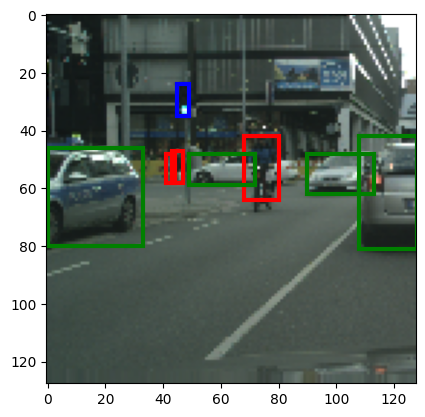

In [ ]:
# COMMENTED TRAINING CODE 

# Show the chosen image with ground truth bounding boxes visualized.
# from matplotlib.patches import Rectangle

# for i in range(len(raw_labels)):
#     if all(x in raw_labels[i][:, 0] for x in [2, 1, 0]):
#         image_index = i
#         break

# # Chosen image is the one with all three classes: index = image_index
# image_with_bounding_boxes = images[8].copy()

# fig, ax = plt.subplots()
# ax.imshow(image_with_bounding_boxes)
# label = raw_labels[8:9][0]
# for i in range(len(label)):
#     x_tl = label[i,1]
#     y_tl = label[i,2]
#     x_br = label[i,3]
#     y_br = label[i,4]

#     if (label[i,0] == 0):
#         plt.gca().add_patch(Rectangle((x_tl, y_tl), x_br-x_tl, y_br-y_tl, linewidth=3, edgecolor='red', facecolor='none'))

#     if (label[i,0] == 1):
#         plt.gca().add_patch(Rectangle((x_tl, y_tl), x_br-x_tl, y_br-y_tl, linewidth=3, edgecolor='blue', facecolor='none'))

#     if (label[i,0] == 2):
#         plt.gca().add_patch(Rectangle((x_tl, y_tl), x_br-x_tl, y_br-y_tl, linewidth=3, edgecolor='green', facecolor='none'))

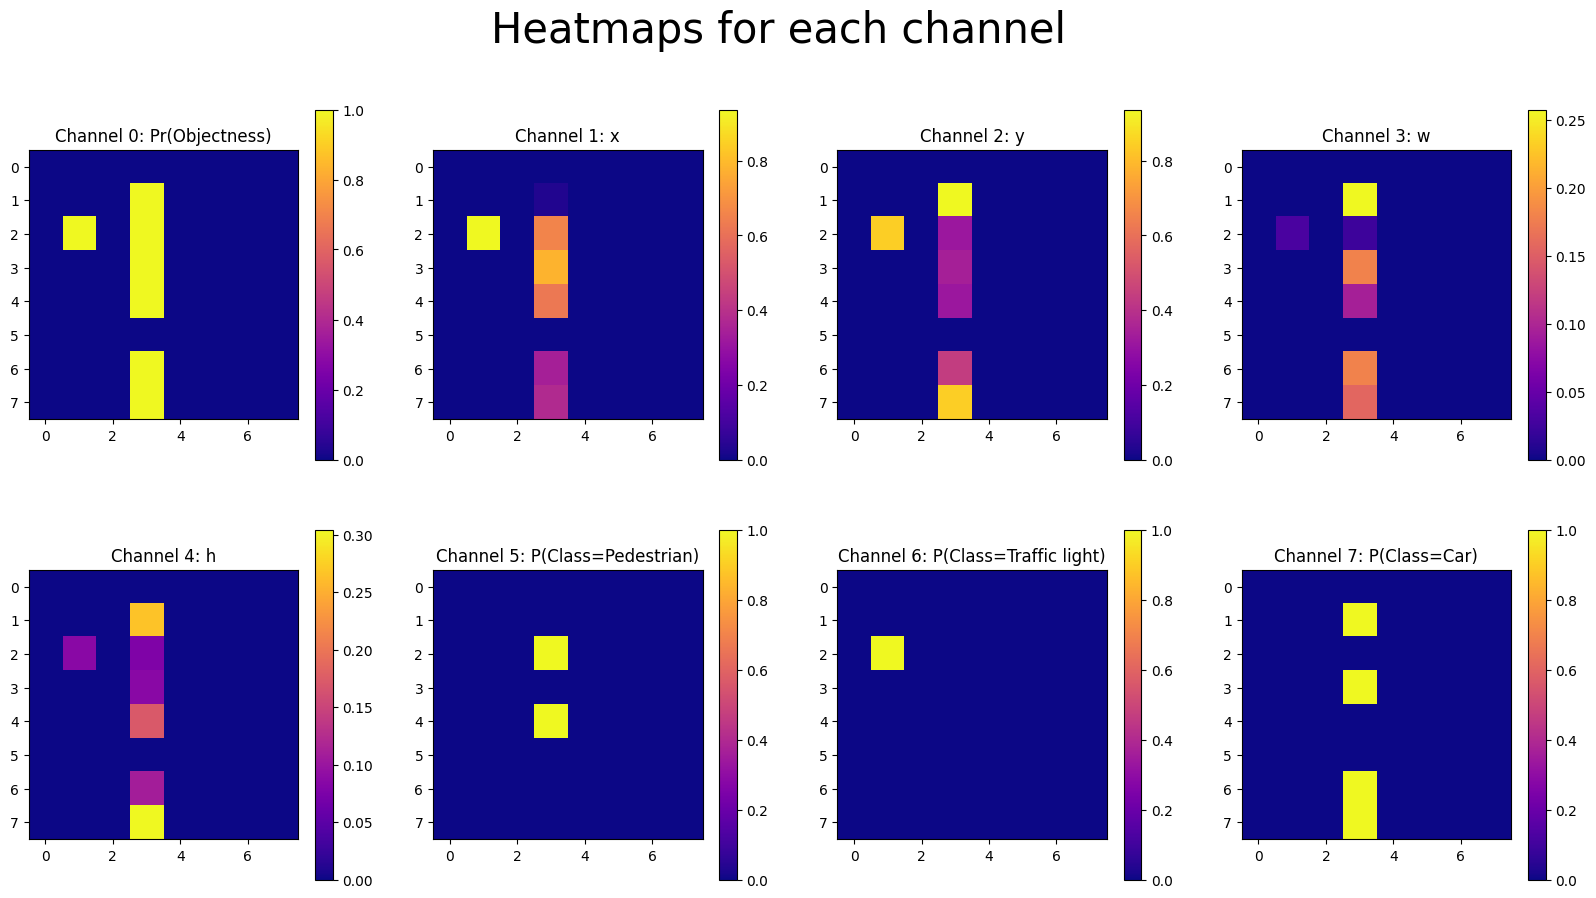

In [ ]:
# COMMENTED TRAINING CODE AS PER INSTRUCTIONS

# # Visualize the 8x8x8 representation.

# labels = np.array(process_labels(raw_labels))

# channel_titles = [
#     "Channel 0: Pr(Objectness)",
#     "Channel 1: x",
#     "Channel 2: y",
#     "Channel 3: w",
#     "Channel 4: h",
#     "Channel 5: P(Class=Pedestrian)",
#     "Channel 6: P(Class=Traffic light)",
#     "Channel 7: P(Class=Car)"
# ]

# fig, axarr = plt.subplots(2, 4, figsize=(20, 10))
# fig.suptitle('Heatmaps for each channel', fontsize=30)

# # Iterate over channels and plot them
# for i in range(2):
#     for j in range(4):
#         channel_idx = 4*i + j
#         heatmap = axarr[i, j].imshow(labels[image_index][channel_idx], cmap="plasma")
#         axarr[i, j].set_title(channel_titles[channel_idx])
#         plt.colorbar(heatmap, ax=axarr[i, j])

# plt.show()

<ipython-input-12-7a96e8a99c23>:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  raw_labels = np.array(reconstructed_labels)


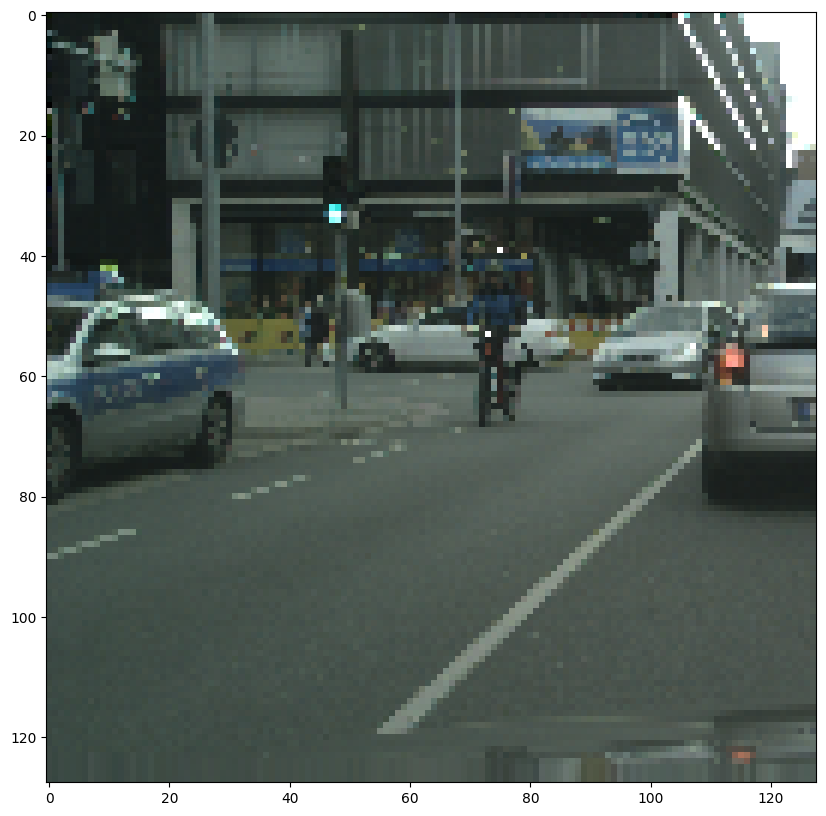

In [ ]:
# COMMENTED TRAINING CODE AS PER INSTRUCTIONS

# # Convert back to the original representation (test cases below should pass).

# # Reconstruct labels
# reconstructed_labels = reconstruct_raw_labels(labels)

# # Get labels for the image of interest
# current_labels = reconstructed_labels[image_index]

# # Create a copy of the selected image for editing
# selected_image = images[image_index].copy()

# # Define colors for different classes
# class_colors = {
#     0: (255, 0, 0),  # blue for traffic light
#     1: (0, 0, 255),  # red for pedestrian
#     2: (0, 255, 0)   # green for car
# }

# # Display the edited image
# plt.figure(figsize=(10, 10))
# plt.imshow(selected_image)

Block diagram of architecture. 

The only change we made is that we added a softmax layer after the conv9 layer.

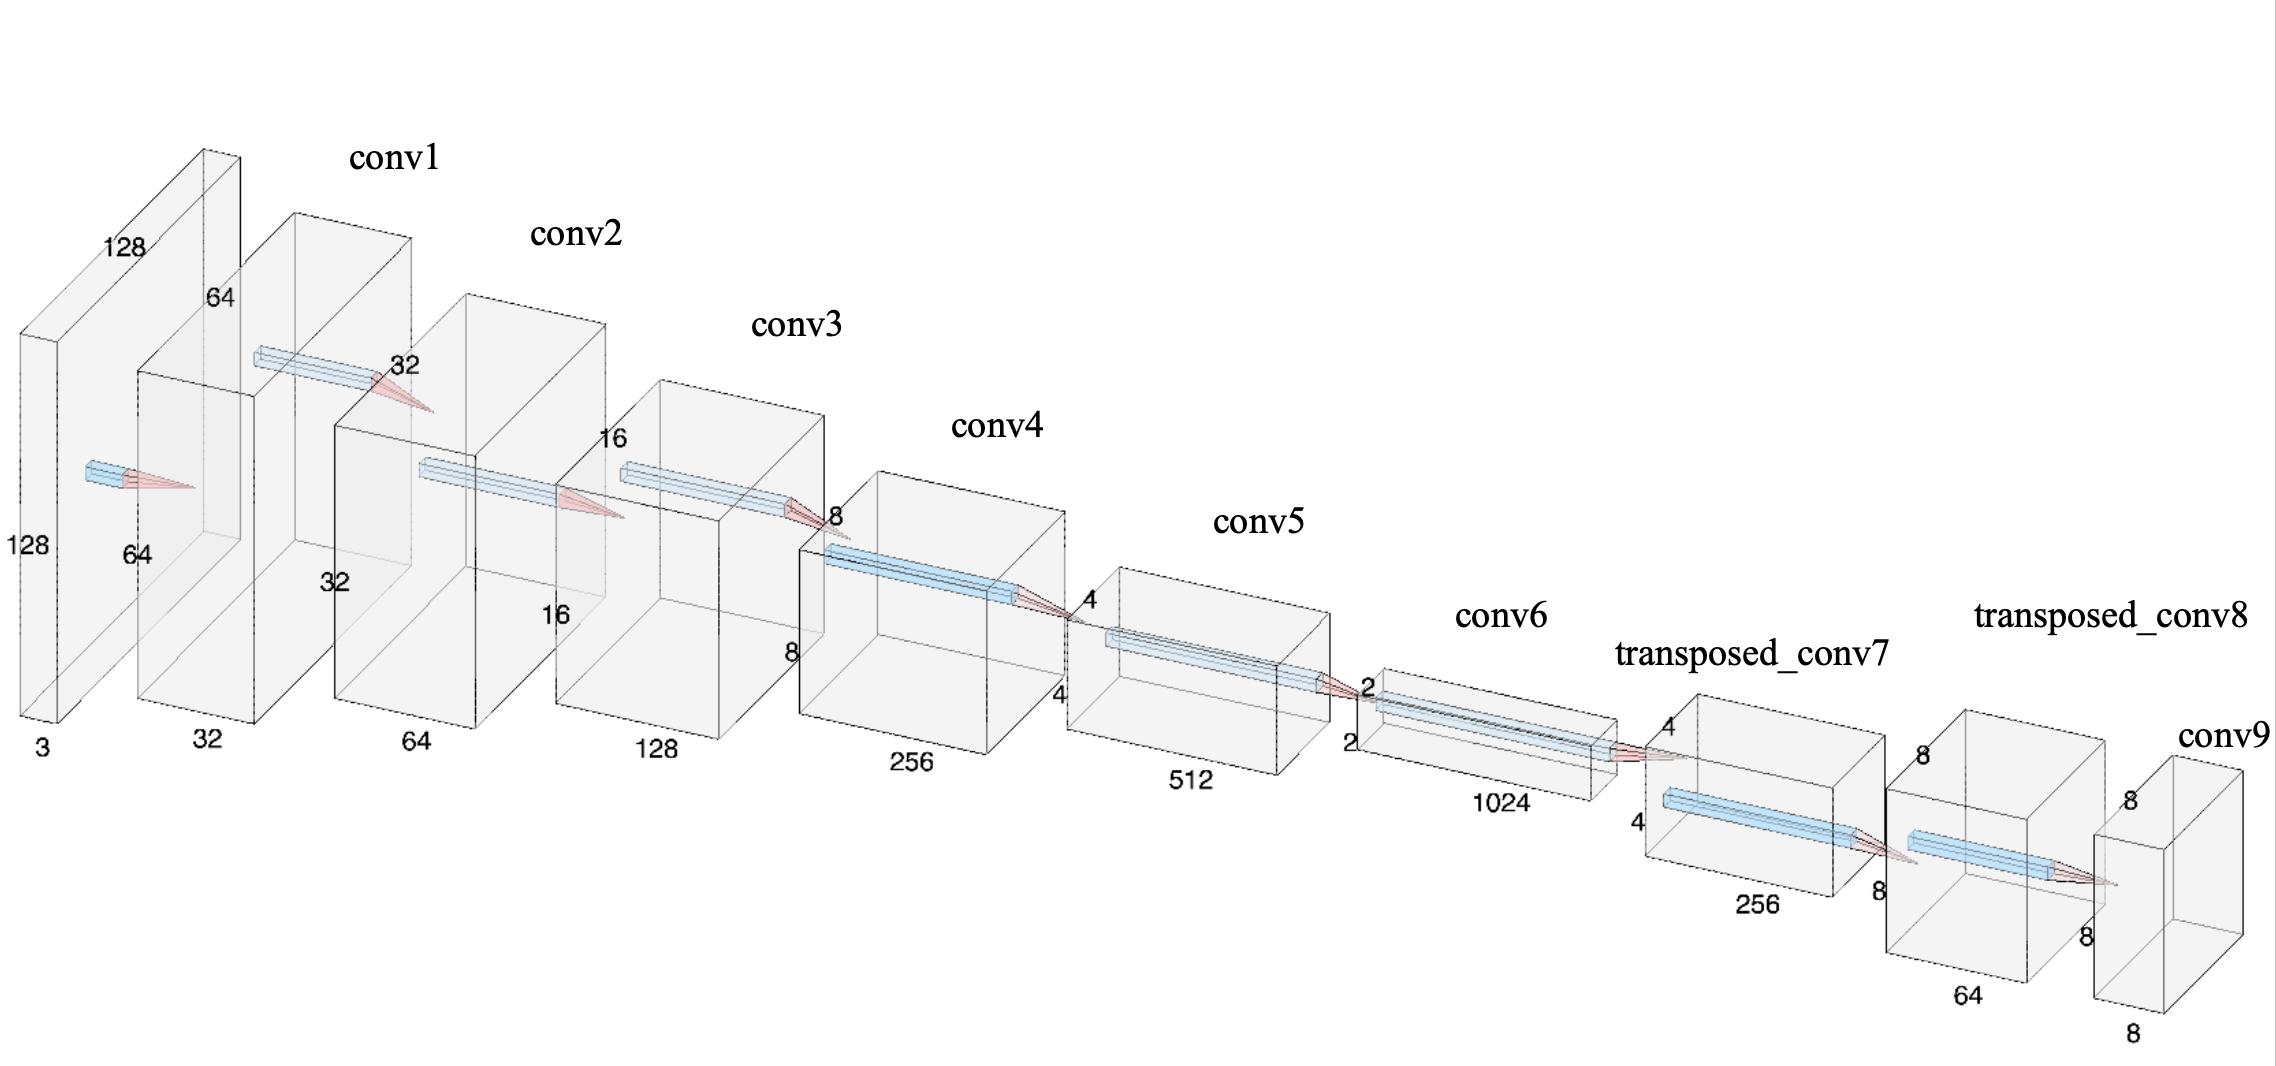

Plot of the loss over training for your model. 

In [ ]:
# COMMENTED TRAINING CODE 

# import torchvision
# from torch.utils.data import DataLoader, TensorDataset

# model = YOLO().to(device)

# checkpoint_callback = pl_callbacks.ModelCheckpoint(dirpath = "checkpoint_folder/", monitor = "epoch", filename = "{epoch}", save_top_k = 50)
# tb_logger = pl_loggers.TensorBoardLogger("log/")
# batch_size = 64

# all_images = torch.Tensor(images)
# all_images = torch.permute(all_images, (0, 3, 1, 2))   #To convert the shape from ( N, Height, Width, Channels) to ( N, Channels, Height, Width)

# all_processed_labels = torch.Tensor(process_labels(raw_labels))  #getting raw_labels from [x1, y1, x2, y2] form to [objectness, bx, by, bw, bh, c1, c2, c3] form for all grid cells
# #print(all_processed_labels.shape)

# #Splitting into train and test sets
# train_images = all_images[:8910]
# train_labels = all_processed_labels[:8910]

# #Using 10% of the data for validation
# test_images = all_images[8910:]
# test_labels = all_processed_labels[8910:]
# #print(test_labels.shape)

# TrainDataset = TensorDataset(train_images, train_labels)
# TestDataset = TensorDataset(test_images, test_labels)

# train_loader = DataLoader(TrainDataset,batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(TrainDataset,batch_size=batch_size, shuffle=True)

In [ ]:
# COMMENTED TRAINING CODE

# trainer = pl.Trainer(accelerator='gpu', devices=1, logger=tb_logger, max_epochs=30, callbacks=[checkpoint_callback])
# trainer.fit(model, train_loader, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type       | Params
----------------------------------------------
0 | feature_layers | Sequential | 11.2 M
1 | decoder_layers | Sequential | 4.5 M 
----------------------------------------------
15.6 M    Trainable params
0         Non-trainable params
15.6 M    Total params
62.574    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


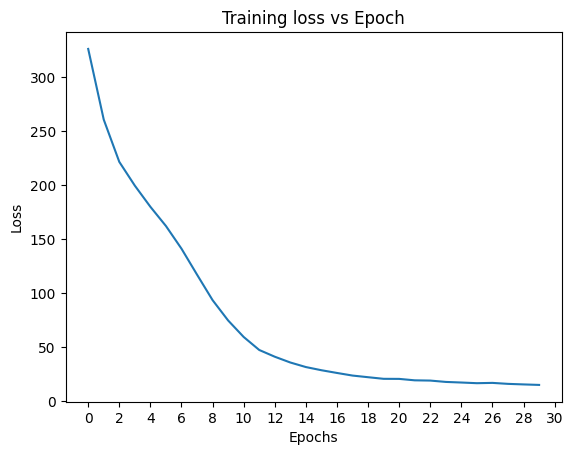

In [ ]:
# COMMENTED PLOT CODE

# # Calculate number of batches per epoch
# batches_per_epoch = len(train_loader)

# # Compute average loss for each epoch
# epoch_losses = [sum(model.training_losses[i:i+batches_per_epoch]) / batches_per_epoch for i in range(0, len(model.training_losses), batches_per_epoch)]

# # Plotting the average loss per epoch
# plt.plot(epoch_losses)
# plt.xticks([k for k in range(0, len(epoch_losses)+1, 2)])
# plt.title("Training loss vs Epoch")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.show()

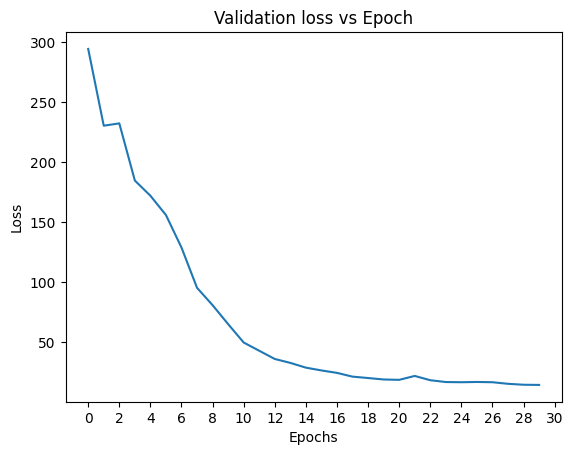

In [ ]:
# COMMENTED PLOT CODE 

# # Calculate number of batches per epoch for validation
# # Typically, this should be the length of your test_loader or validation loader.
# batches_per_epoch = len(test_loader)

# # Compute average loss for each epoch
# epoch_losses = [sum(model.validation_losses[i:i+batches_per_epoch]) / batches_per_epoch for i in range(0, len(model.validation_losses), batches_per_epoch)]

# # Plotting the average loss per epoch
# plt.plot(epoch_losses)
# plt.xticks([k for k in range(0, len(epoch_losses)+1, 2)])
# plt.title("Validation loss vs Epoch")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.show()

5. Show a plot of the mean Average Precision over training for your model. (10%)

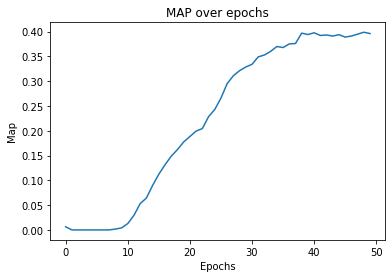

In [ ]:
# COMMENTED PLOT CODE 

# NMS_THRESHOLD = 0.5
# DETECTION_THRESHOLD = 0.5

# def calculate_epoch_map(predictions_per_epoch):
#     """
#     Calculate mean average precision for each epoch based on the model's predictions.

#     Args:
#     - predictions_per_epoch (list): Nested list with model predictions for each epoch.

#     Returns:
#     - List with MAP values for each epoch.
#     """
#     map_values = []

#     for epoch_predictions in predictions_per_epoch:
#         epoch_map = sum([
#             mean_average_precision(
#                 non_max_suppression(batch_prediction, nms_thres=NMS_THRESHOLD),
#                 reconstruct_raw_labels(batch_prediction.cpu().detach().numpy(), thr=DETECTION_THRESHOLD)
#             )
#             for batch_prediction in epoch_predictions
#         ])
#         map_values.append(epoch_map / (len(epoch_predictions) + 1e-5))

#     return map_values

# # Calculate MAP for each epoch
# map_epoch = calculate_epoch_map(model.prediction_per_epoch)

# # Plotting the MAP per epoch
# plt.plot(map_epoch)
# plt.title("MAP over epochs")
# plt.xlabel("Epochs")
# plt.ylabel("MAP")
# plt.show()

For one image in the inference step, showed the predicted bounding boxes in the image before performing any elimination. Then, showed the annotated image after the low probability bounding boxes are removed. Finally, showed image after performing non-max suppression. Label each of these visualizations.

In [ ]:
# predictions = model(torch.tensor(images[:100],dtype=torch.float32).reshape(100,3,128,128))

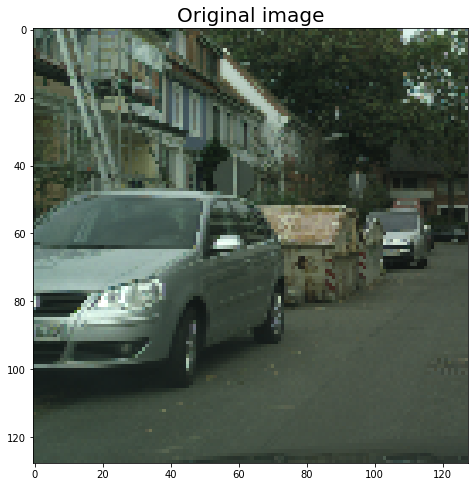

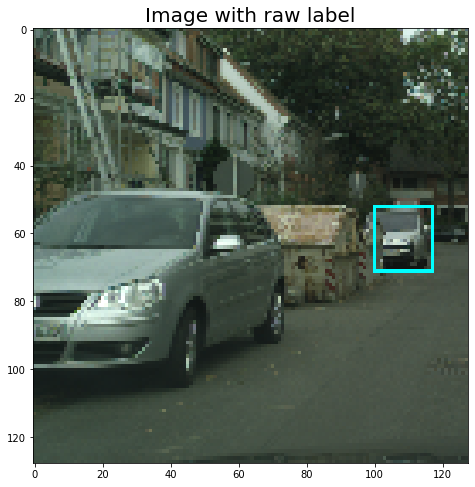

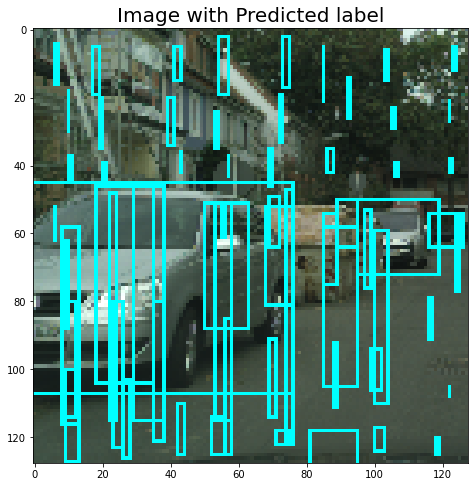

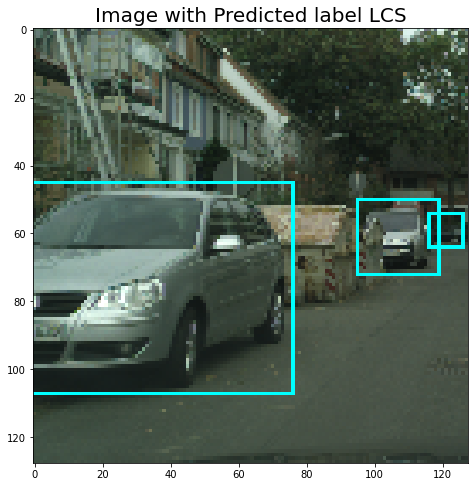

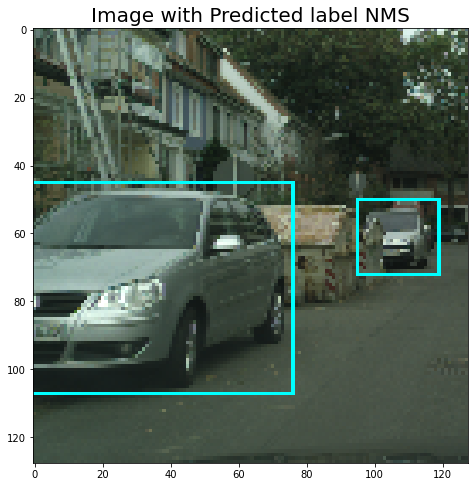

In [ ]:
# COMMENTED PLOT CODE 

# def plot_bounding_boxes(image, boxes, title="", color=(0, 255, 255)):
#     """
#     Display the image with bounding boxes.
#     Args:
#     - image: The original image.
#     - boxes: List of bounding boxes [x_ul, y_ul, x_br, y_br].
#     - title: Title for the plot.
#     - color: Color of the bounding boxes.
#     """
#     img_copy = image.copy()
#     for box in boxes:
#         x_ul, y_ul, x_br, y_br = [int(coord) for coord in box[1:5]]
#         img_copy = cv2.rectangle(img_copy, (x_ul, y_ul), (x_br, y_br), color, 1)

#     plt.figure(figsize=(8, 8))
#     plt.title(title, size=20)
#     plt.imshow(img_copy)
#     plt.axis('off')

# disp_img_number = 42

# # Original image
# plot_bounding_boxes(images[disp_img_number], [], "Original Image")

# # Raw Labels
# plot_bounding_boxes(images[disp_img_number], raw_labels[disp_img_number], "Image with Raw Labels")

# # Raw Predictions
# raw_preds = reconstruct_raw_labels([predictions[disp_img_number].detach().numpy()], conf=False, thr=0.00, img_dim=128)
# plot_bounding_boxes(images[disp_img_number], raw_preds[0], "Image with Predicted Label")

# # LCS Predictions
# lcs_labels = reconstruct_raw_labels([low_confidence_suppression(predictions[disp_img_number]).detach().numpy()], conf=False, thr=0.00, img_dim=128)
# plot_bounding_boxes(images[disp_img_number], lcs_labels[0], "Image with Predicted Label LCS")

# # NMS Predictions
# nms_boxes = non_max_suppression(torch.tensor([low_confidence_suppression(predictions[disp_img_number]).detach().numpy()]), nms_thres=0.0)[0]
# nms_boxes_combined = [box for sublist in nms_boxes for box in sublist if len(box) != 0]
# plot_bounding_boxes(images[disp_img_number], nms_boxes_combined, "Image with Predicted Label NMS")

# plt.show()


For one image in the inference step, showed the bounding boxes visualized for each class with green bounding boxes around cars, red bounding boxes around pedestrians, and blue bounding boxes around traffic lights. Showed the precision/recall curves for each class in inference. 

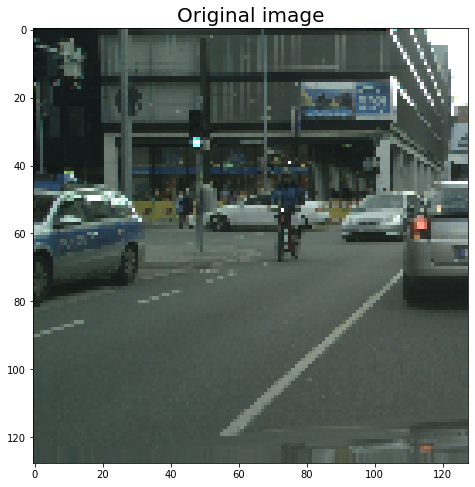

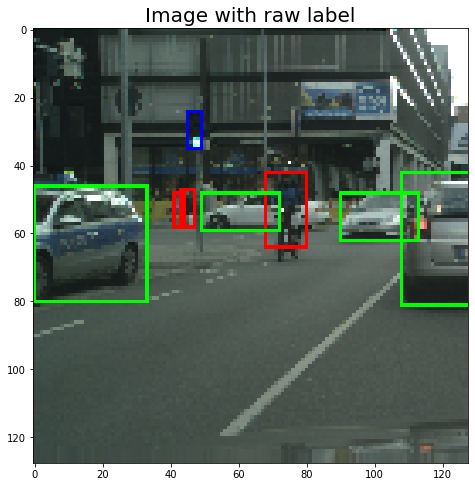

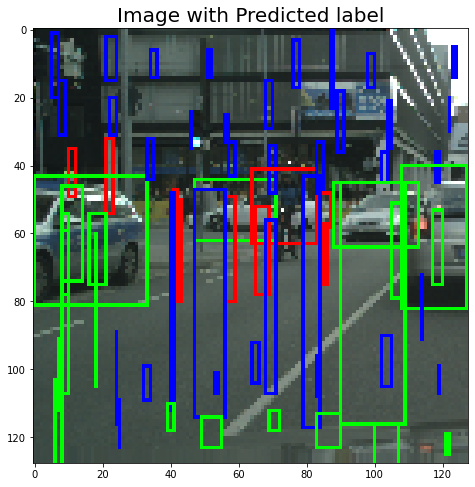

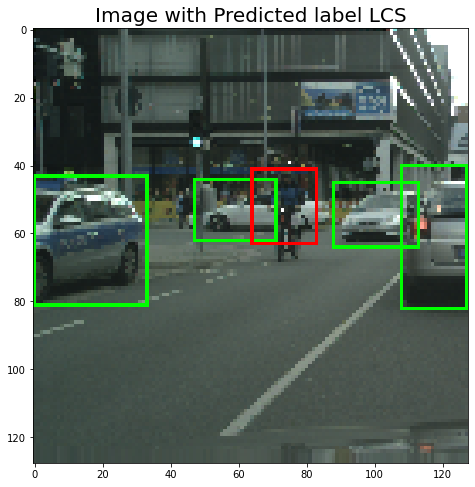

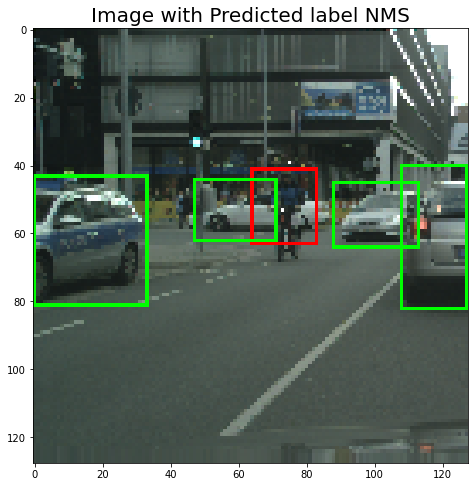

In [ ]:
# COMMENTED PLOT CODE 

# def plot_bounding_boxes(image, boxes, title="", colors=[(255, 0, 0), (0, 0, 255), (0, 255, 0)]):
#     """
#     Display the image with colored bounding boxes based on class.
#     Args:
#     - image: The original image.
#     - boxes: List of bounding boxes [class, x_ul, y_ul, x_br, y_br].
#     - title: Title for the plot.
#     - colors: List of colors for each class.
#     """
#     img_copy = image.copy()
#     for box in boxes:
#         cls, x_ul, y_ul, x_br, y_br = [int(coord) if idx > 0 else coord for idx, coord in enumerate(box)]
#         img_copy = cv2.rectangle(img_copy, (x_ul, y_ul), (x_br, y_br), colors[cls], 1)

#     plt.figure(figsize=(8, 8))
#     plt.title(title, size=20)
#     plt.imshow(img_copy)
#     plt.axis('off')

# disp_img_number = 8

# # Original image
# plt.figure(figsize=(8,8))
# plt.title("Original Image", size=20)
# plt.imshow(images[disp_img_number])
# plt.axis('off')

# # Raw Labels
# plot_bounding_boxes(images[disp_img_number], raw_labels[disp_img_number], "Image with Raw Labels")

# # Raw Predictions
# raw_preds = reconstruct_raw_labels([predictions[disp_img_number].detach().numpy()], conf=False, thr=0.00, img_dim=128)
# plot_bounding_boxes(images[disp_img_number], raw_preds[0], "Image with Predicted Label")

# # LCS Predictions
# lcs_labels = reconstruct_raw_labels([low_confidence_suppression(predictions[disp_img_number]).detach().numpy()], conf=False, thr=0.00, img_dim=128)
# plot_bounding_boxes(images[disp_img_number], lcs_labels[0], "Image with Predicted Label LCS")

# # NMS Predictions
# nms_boxes = non_max_suppression(torch.tensor([low_confidence_suppression(predictions[disp_img_number]).detach().numpy()]), nms_thres=0.6)[0]
# nms_boxes_combined = [box for sublist in nms_boxes for box in sublist if len(box) != 0]
# plot_bounding_boxes(images[disp_img_number], nms_boxes_combined, "Image with Predicted Label NMS")

# plt.show()

Issues or challenges with my implementation.

Creating the code posed significant challenges, particularly calculating the loss function, handling non-maximum suppression (NMS), and generating the precision-recall curve. Additionally, a substantial amount of effort was invested in debugging the code and ensuring its seamless integration to form a cohesive whole. It's our belief that fine-tuning hyperparameters could yield superior results. Extending the number of training epochs and optimizing the learning rate are potential strategies to enhance output. As with most machine learning models, a larger dataset would undoubtedly contribute to improving the model's overall performance. To enhance the model's performance in object detection, we could further consider strategies like employing multiple learning rate schedulers and exploring anchor-free methods, alongside adjustments to network architecture, extended training, and data augmentation. With more we could've experimented with hyperparameter tuning and yield better results.

## Some Useful Online Materials

Original YOLO paper:  
https://arxiv.org/pdf/1506.02640.pdf

Intuitive Explanation:  
https://towardsdatascience.com/yolo-you-only-look-once-real-time-object-detection-explained-492dc9230006

YOLO Video Tutorial:  
https://www.youtube.com/watch?v=9s_FpMpdYW8&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=30

mean Average Precision:  
https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173

Intersection over Union:  
https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection